<h1 align='center'>Welcome to my Notebook</h1>

# Originally taken from:
https://www.kaggle.com/vagifa/vehicle-insurance-eda-undersampling-lightgbm/notebook

In [25]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
#import plotly.express as px
import seaborn as sns

from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold,KFold
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, roc_auc_score, \
                            confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import matthews_corrcoef

from sklearn.model_selection import train_test_split

import optuna
from optuna.samplers import TPESampler
sns.set(style='white', context='notebook', palette='deep')
%config Completer.use_jedi = False

In [ ]:
csl_df = pd.read_csv('/MFMDatasets/MFM_bopf/data/csl/CSL_he_PI_comp.csv', index_col=0)
X = csl_df.drop('high_EBL', axis=1, inplace=False)
y = csl_df['high_EBL'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y,
                                                    random_state=7)

<h1 align='center'>Exploratory Data Analysis</h1>

In [27]:
X.head()

,Accrete,AdmBishop,Admcervpos,Admconsistency,Admcontract,AdmDBP,Admefface,Admpresent,AdmSBP,Analgesia,...,ThreatenedPB,threatpb9,UnspecHBP,uscar,version9,new_age,new_BMI,new_high_Age,new_high_BMI,Sitenum
MomID,,,,,,,,,,,,,,,,,,,,,
41-00003,0,6,3,2,2.9,77,70.0,1,105.0,8,...,0,0,0,0,0,36,22,1,1,41
41-00004,0,5,3,2,3.3,65,70.0,1,122.0,8,...,0,0,0,0,0,34,31,1,1,41
41-00006,0,11,1,3,5.0,98,100.0,77,134.0,8,...,0,0,0,0,0,21,22,1,1,41
41-00007,0,4,2,2,2.9,105,50.0,77,145.0,7,...,0,0,0,0,0,42,24,2,1,41
41-00008,0,6,3,2,6.7,71,70.0,77,118.0,8,...,0,0,0,0,0,33,18,1,0,41


In [30]:
csl_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136487 entries, 41-00003 to 52-07251
Columns: 196 entries, high_EBL to Sitenum
dtypes: float64(4), int64(192)
memory usage: 205.1+ MB


In [31]:
X.skew()

Accrete           37.090262
AdmBishop         -1.514264
Admcervpos        -0.633467
Admconsistency    -0.589096
Admcontract        0.159128
                    ...    
new_age            0.222815
new_BMI            2.154541
new_high_Age      -0.595479
new_high_BMI      -0.458363
Sitenum           -0.152035
Length: 195, dtype: float64

In [9]:
#all_features = pd.concat([train.drop(['id','Response'],axis=1),test.drop('id',axis=1)],axis=0)
#y = train['Response']

Let's combine the train and test set so our transformations are easier as we don't have to apply them seperately to each set

<h1 align='center'>Categorical Features Data Analysis</h1>

In [44]:
%precision %.3f
#np.set_printoptions(precision=3)
print(f'{np.bincount(y)[1]/len(y):.4f}')
print(f'{np.bincount(y_train)[1]/len(y_train):.4f}')

0.0422
0.0422


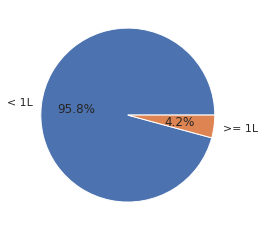

In [33]:
fig1, ax1 = plt.subplots()
ax1.pie(csl_df['high_EBL'].value_counts(), labels=['< 1L','>= 1L'], autopct='%1.1f%%')
plt.show()

In [12]:
#fig = px.pie(train,values=train['Response'].value_counts(),names=['Class 0','Class 1'],hole=0.6,labels={0:'Response = 0'},color_discrete_sequence=px.colors.sequential.Sunset)
#fig.show(showlegend=True)
#plt.show()

In [13]:
#fig = px.pie(train,values=train['Response'].value_counts(),names=['Class 0','Class 1'],hole=0.6,labels={0:'Response = 0'},color_discrete_sequence=px.colors.sequential.Sunset)
#fig.show(showlegend=True)

/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


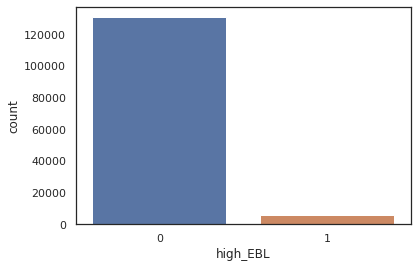

In [34]:
sns.countplot(csl_df['high_EBL'])
plt.show()

We can see from the above visualisations that:

* The Data is highly imbalanced

/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


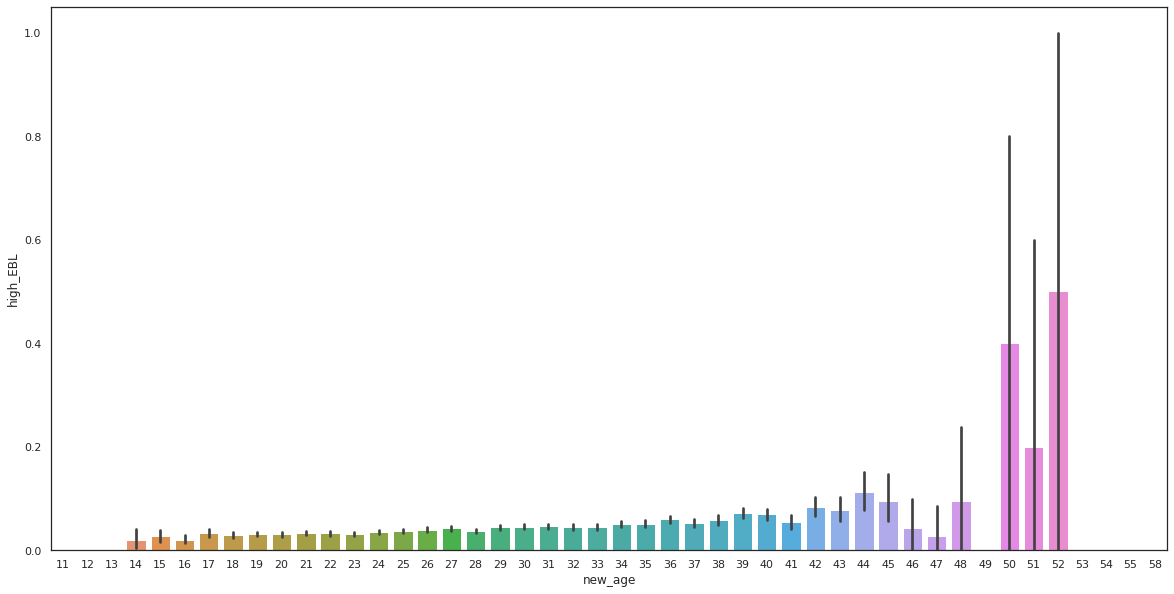

In [35]:
plt.figure(figsize=(20,10))
sns.barplot(csl_df['new_age'],csl_df['high_EBL'])
plt.show()

/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


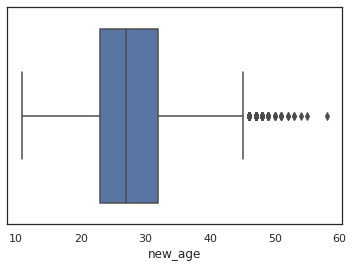

In [19]:
sns.boxplot(csl_df['new_age'])
plt.show()

/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


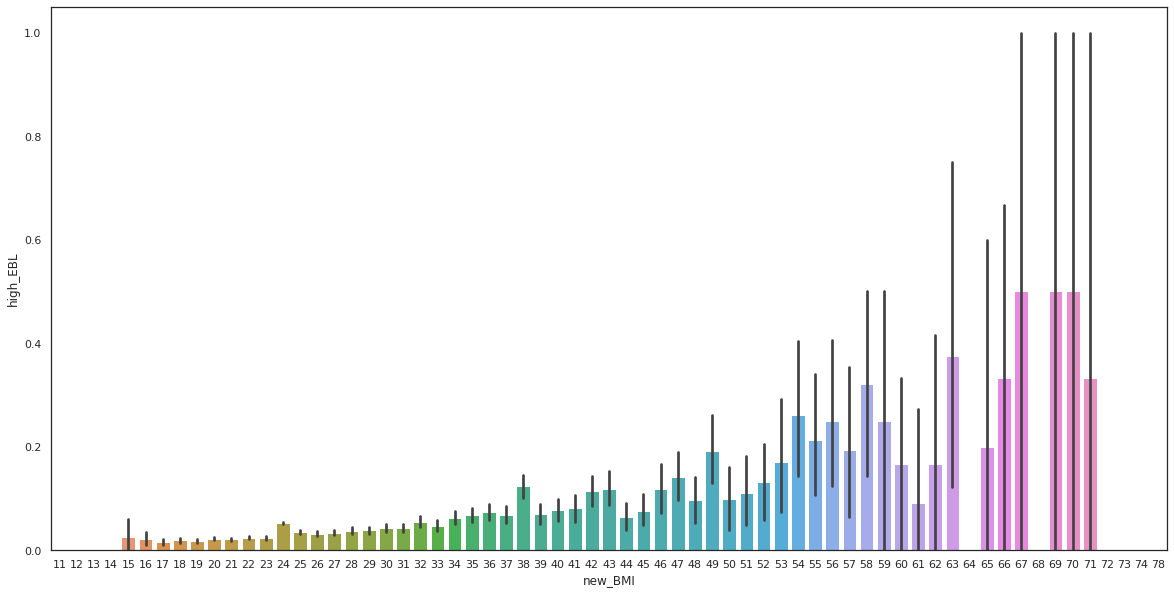

In [20]:
plt.figure(figsize=(20,10))
sns.barplot(csl_df['new_BMI'],csl_df['high_EBL'])
plt.show()

/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


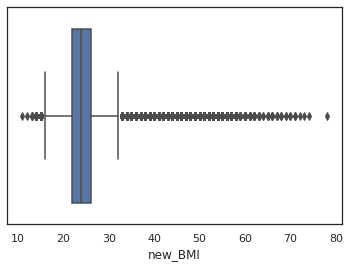

In [21]:
sns.boxplot(csl_df['new_BMI'])
plt.show()

<h1 align='center'>Modelling</h1>

In [28]:
#X = all_features.iloc[:len(train),:]
#X_test = all_features.iloc[len(train):,:]

#kf = StratifiedKFold(n_splits=12,shuffle=True,random_state=42)

We define resplit our train and test set, and set up 12 Fold Stratified Cross Validation. It is important to stratify as this ensures that during our training and validation, we split according to target distribution

In [29]:
#for train_index,val_index in kf.split(X,y):
#    X_train,X_val = X.iloc[train_index],X.iloc[val_index],
#    y_train,y_val = y.iloc[train_index],y.iloc[val_index],

In [46]:
# MWB
print(X_train.shape)
print(X.shape)
print(y.shape)

(95540, 195)
(136487, 195)
(136487,)


Here we define our validation set

<h1 align='center'>Modelling Using Undersampling</h1>

We will use `imblearn`'s RandomUnderSampler to undersample from the majority class so that they match

In [45]:
sampler = RandomUnderSampler(sampling_strategy=1.0, random_state=7)
X_rus, y_rus = sampler.fit_resample(X_train, y_train)

In [48]:
print(X_rus.shape)
print(y_rus.shape)
print(np.bincount(y_rus))

(8064, 195)
(8064,)
[4032 4032]


<h1 align='center'>Basic LightGBM</h1>

Let's fit a vanilla LGBMClassifier on the undersampled data and evaluate it

In [54]:
from sklearn.metrics import matthews_corrcoef
lgb_rus = LGBMClassifier()
lgb_rus.fit(X_rus, y_rus)
y_pred = lgb_rus.predict(X_test)
print(confusion_matrix(y_pred=y_pred, y_true=y_test))
print(classification_report(y_test, y_pred))
print(f'ROC AUC Score: {roc_auc_score(y_test, y_pred)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred)}')

[[30820  8399]
 [  197  1531]]
              precision    recall  f1-score   support

           0       0.99      0.79      0.88     39219
           1       0.15      0.89      0.26      1728

    accuracy                           0.79     40947
   macro avg       0.57      0.84      0.57     40947
weighted avg       0.96      0.79      0.85     40947

ROC AUC Score: 0.8359194832932451
MCC: 0.31514527276704923


<h1 align='center'>Hyperparameter Tuning</h1>

In [56]:
def create_model(trial):
    n_estimators = trial.suggest_int('n_estimators',100,500)
    num_leaves = trial.suggest_int('num_leaves',10,500)
    max_depth = trial.suggest_int('max_depth',4,20)
    learning_rate = trial.suggest_uniform('learning_rate',0.0001,1)
    min_child_samples = trial.suggest_int('min_child_samples',10,50)
#    model = LGBMClassifier(n_estimators=n_estimators, num_leaves=num_leaves, 
#                           max_depth=max_depth, learning_rate=learning_rate, 
#                           min_child_samples=min_child_samples, class_weight='balanced')
    model = LGBMClassifier(n_estimators=n_estimators, num_leaves=num_leaves, 
                           max_depth=max_depth, learning_rate=learning_rate, 
                           min_child_samples=min_child_samples)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_rus, y_rus)
    #score = roc_auc_score(y_val,model.predict(X_val))
    score = matthews_corrcoef(y_test, model.predict(X_test))  # MWB
    return score

sampler = TPESampler(seed=42)
study = optuna.create_study(sampler=sampler,direction='maximize')
study.optimize(objective,n_trials=60)

[I 2021-11-30 18:41:00,088] A new study created in memory with name: no-name-82096b05-1bcf-4d71-9cad-e730aadf253e
[I 2021-11-30 18:41:01,641] Trial 0 finished with value: 0.2993033882418646 and parameters: {'n_estimators': 250, 'num_leaves': 476, 'max_depth': 16, 'learning_rate': 0.5986986183486169, 'min_child_samples': 16}. Best is trial 0 with value: 0.2993033882418646.
[I 2021-11-30 18:41:02,290] Trial 1 finished with value: 0.2950260651391619 and parameters: {'n_estimators': 162, 'num_leaves': 38, 'max_depth': 18, 'learning_rate': 0.6011549002420344, 'min_child_samples': 39}. Best is trial 0 with value: 0.2993033882418646.
[I 2021-11-30 18:41:03,607] Trial 2 finished with value: 0.30500315771102937 and parameters: {'n_estimators': 108, 'num_leaves': 486, 'max_depth': 18, 'learning_rate': 0.21241787676720833, 'min_child_samples': 17}. Best is trial 2 with value: 0.30500315771102937.
[I 2021-11-30 18:41:04,845] Trial 3 finished with value: 0.30110732571590554 and parameters: {'n_esti

[I 2021-11-30 18:41:49,799] Trial 30 finished with value: 0.3022130576294397 and parameters: {'n_estimators': 117, 'num_leaves': 358, 'max_depth': 11, 'learning_rate': 0.28419076646436664, 'min_child_samples': 34}. Best is trial 19 with value: 0.3219404644321208.
[I 2021-11-30 18:41:51,598] Trial 31 finished with value: 0.309323980676666 and parameters: {'n_estimators': 453, 'num_leaves': 221, 'max_depth': 9, 'learning_rate': 0.06470861479578509, 'min_child_samples': 48}. Best is trial 19 with value: 0.3219404644321208.
[I 2021-11-30 18:41:53,108] Trial 32 finished with value: 0.30277118148353954 and parameters: {'n_estimators': 466, 'num_leaves': 204, 'max_depth': 7, 'learning_rate': 0.1750841453254722, 'min_child_samples': 46}. Best is trial 19 with value: 0.3219404644321208.
[I 2021-11-30 18:41:54,956] Trial 33 finished with value: 0.3066738682867458 and parameters: {'n_estimators': 387, 'num_leaves': 304, 'max_depth': 13, 'learning_rate': 0.07805498401213935, 'min_child_samples': 5

In [61]:
lgb_params = study.best_params
lgb_params['random_state'] = 42
lgb = LGBMClassifier(**lgb_params)
lgb.fit(X_rus, y_rus)
preds = lgb.predict(X_test)
print(classification_report(y_test,lgb.predict(X_test)))
print(f'ROC AUC Score: {roc_auc_score(y_test, preds)}')
print(f'MCC: {matthews_corrcoef(y_test, preds)}')

              precision    recall  f1-score   support

           0       0.99      0.79      0.88     39219
           1       0.16      0.89      0.27      1728

    accuracy                           0.80     40947
   macro avg       0.58      0.84      0.58     40947
weighted avg       0.96      0.80      0.86     40947

ROC AUC Score: 0.839654917649042
MCC: 0.3219404644321208


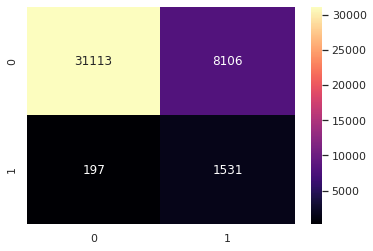

In [64]:
sns.heatmap(confusion_matrix(y_test, preds), cmap='magma', annot=True, fmt='g')
plt.show()

In [65]:
lgb_params

{'n_estimators': 214,
 'num_leaves': 426,
 'max_depth': 20,
 'learning_rate': 0.011,
 'min_child_samples': 44,
 'random_state': 42}

<h1 align='center'>Thanks and make sure to learn!</h1>